In [2]:
# analytical solution for X:A given Ne, G, V histories
import math

class solvePoly(object):
    
    def __init__(self, T, NeA, GM, GF, VR, um=(1.41,5.5), uf=(0.39,2.04)):
        
        # save input variable
        self._T = T
        self._NeA = NeA
        self._GM = GM
        self._GF = GF
        self._VR = VR
        self._um = um
        self._uf = uf
        
        assert T[0] == 0.0
        self._n = len(T)
        assert self._n == len(NeA)
        assert self._n == len(GM)
        assert self._n == len(GF)
        assert self._n == len(VR)
        assert min([T[i+1]-T[i] for i in range(self._n-1)]) > 0
        
        # calculate GX, GA
        self._GX = [GM[i]/3.0 + 2.0*GF[i]/3.0 for i in range(self._n)]
        self._GA = [0.5*GM[i] + 0.5*GF[i] for i in range(self._n)]
        
        # calculate NeX
        self._NeX = [self._f(self._GM[i]/self._GF[i])*self._NeA[i]/self._f(VR[i]) for i in range(self._n)]
        
        # calculate piA, piX at the segments endpoints
        self._piA = [0.0 for _ in range(self._n)]
        self._piA[-1] = 4.0*self._NeA[-1]*self._uA(self._GM[-1],self._GF[-1])
        for i in range(self._n-2,-1,-1):
            w = math.exp(-(self._T[i+1]-self._T[i])/(2.0*self._GA[i]*self._NeA[i]))
            t = 4.0*self._NeA[i]*self._uA(self._GM[i],self._GF[i])
            self._piA[i] = (1-w)*t + w*self._piA[i+1]
        
        self._piX = [0.0 for _ in range(self._n)]
        self._piX[-1] = 3.0*self._NeX[-1]*self._uX(self._GM[-1],self._GF[-1])
        for i in range(self._n-2,-1,-1):
            w = math.exp(-(self._T[i+1]-self._T[i])/(1.5*self._GX[i]*self._NeX[i]))
            t = 3.0*self._NeX[i]*self._uX(self._GM[i],self._GF[i])
            self._piX[i] = (1-w)*t + w*self._piX[i+1]
           
    def _f(self, x):
        return ((2.0*x+4.0)/(3.0*x+3.0))
    
    def _uM(self,GM):
        return self._um[0]*GM+self._um[1]
    
    def _uF(self,GF):
        return self._uf[0]*GF+self._uf[1]
    
    def _uX(self,GM,GF):
        return (2.0*self._uF(GF)+self._uM(GM))/3.0

    def _uA(self,GM,GF):
        return 0.5*self._uF(GF)+0.5*self._uM(GM)
    
    def ratio(self):
        return self._piX[0]/self._piA[0]

    def _binTime(self, t):
        res = self._n - 1
        while t < self._T[res]:
            #print t, res, self._T[res]
            res -= 1
        return res
            
    def piA(self,t):
        # bin T
        tBin = self._binTime(t)
        
        if tBin == (self._n - 1):
            return self._piA[-1]
        else:
            w = math.exp(-(self._T[tBin+1]-t)/(2.0*self._GA[tBin]*self._NeA[tBin]))
            t = 4.0*self._NeA[tBin]*self._uA(self._GM[tBin],self._GF[tBin])
            return (1-w)*t + w*self._piA[tBin+1]
    
    
    def piX(self, t):
        # bin T
        tBin = self._binTime(t)
        
        if tBin == (self._n - 1):
            return self._piX[-1]
        else:
            w = math.exp(-(self._T[tBin+1]-t)/(1.5*self._GX[tBin]*self._NeX[tBin]))
            t = 3.0*self._NeX[tBin]*self._uX(self._GM[tBin],self._GF[tBin])
            return (1-w)*t + w*self._piX[tBin+1]
        

In [3]:
# read population size histories; identify number of ind. time segments
# read inferred values from Schiffels & Durbin
# (click on the figure in the journal's website, and download excel file)
# we remove all entries where there are comments

import pandas
import math
from collections import defaultdict
df = pandas.read_excel('ng.3015-f3.xlsx')

Ts = list(df['Left Boundary [years ago]'].values)
Nes = list(df['Value'].values)
haploCount = list(df['Nr of Haplotypes'].values)
pop = list(df['Population'].values)
comment = list(df['Comment'].values)


inds = [i for i in xrange(len(Ts)) if Ts[i] == 0]
ver = defaultdict(int)
dataset = {}

inds.append(len(Ts))
for k in xrange(len(inds)-1):
    i, nexti = inds[k], inds[k+1]
    if isinstance(comment[i],float):
        if math.isnan(comment[i]):
            ver[haploCount[i], pop[i]] += 1
            dataset[haploCount[i], pop[i]] = (Ts[i:nexti],Nes[i:nexti])

for k in ver:
    assert ver[k] == 1
    

In [4]:
from zipfile import ZipFile
import fnmatch
import numpy as np

dir_ = 'resample/12_18_resample_B/'

# read bootstrap results
def readFile(mode,pop):
    name = '%s.'%pop
    if mode == 'X':
        name += 'x'
    else:
        pass
    name += 'pi_bd.b%d_%d.x_aut_ratios.npz'%(600, 900)

    t = np.load(dir_ + name)['bstrp']
    piOverBD, pi, D, B = t[:,0], t[:,1], t[:,2], t[:,3]
    
    return piOverBD, pi, D, B



1.2600000000000005
(5.470723602966026, 3.891585808590647, 8.202506181261299)


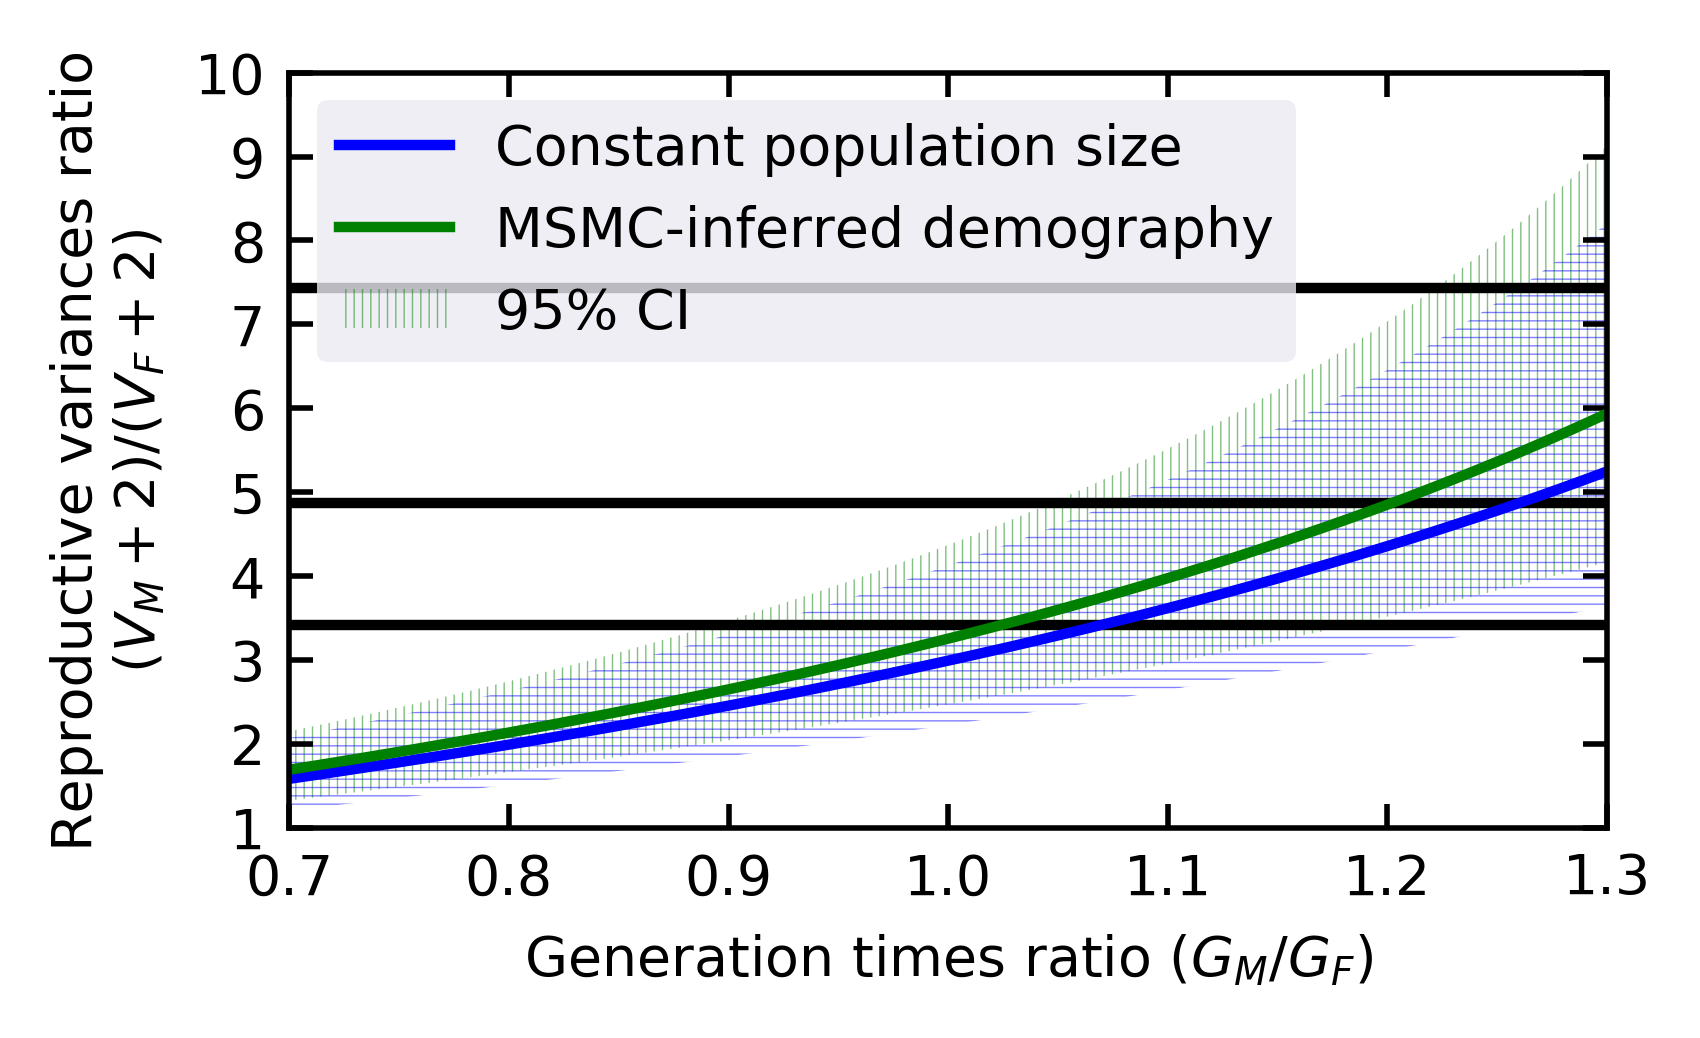

In [8]:
# plot V-ratio as a function of GM/GF
# set high DPI on figures globally
import numpy as np
%matplotlib inline
import seaborn as sns
import matplotlib as mpl
import random
import scipy as sp

mpl.rcParams['figure.dpi'] = 500
mpl.rcParams['axes.titlesize'] = 16
mpl.rcParams['axes.labelsize'] = 8
mpl.rcParams['xtick.labelsize'] = 8
mpl.rcParams['ytick.labelsize'] = 8
mpl.rcParams['legend.fontsize'] = 8

plt = mpl.pyplot
plt.figure(figsize=(3.4,2)) 

GR = np.arange(0.7, 1.3, 0.01)
G1 = 56
print(GR[G1])
GM = GR*30.35*2/(1.0+GR)
GF = 30.35*2/(1.0+GR)
plt.gca().set_xlim([0.7,1.3])

def f(x):
    return (2*x+4.0)/(3*x+3.0)

def alpha(GM, GF):
    return (1.41*GM+5.5)/(0.39*GF+2.04)

def ratioPanmictic(GM, GF, VR):
    ratio = 0.75*f(GM/GF)*f(alpha(GM,GF))/f(VR)
    DivRatio = 0.891
    return ratio/DivRatio

T, Ne = dataset[2,'YRI']
nTotal = len(T)

# read observed ratios
xRes, aRes = readFile('X','YRI')[0], readFile('A','YRI')[0]
l = [random.choice(xRes)/random.choice(aRes) for _ in xrange(20000)]
mean = np.average(l)
upper = np.percentile(l, 97.5)
lower = np.percentile(l, 2.5)

def ratioDemography(GM, GF, VR):
    ratio = solvePoly(T, Ne, [GM]*nTotal, [GF]*nTotal, [VR]*nTotal).ratio()
    DivRatio = 0.891
    return ratio/DivRatio

def solveVR(rFunc, targetVal):
    return [sp.optimize.root(lambda VR: (rFunc(GM[i],GF[i],VR)-targetVal), 1.0).x[0] for i in range(len(GM))]

plt = mpl.pyplot
mpl.rcParams['hatch.linewidth'] = 0.2
plt.plot(GR, solveVR(ratioPanmictic,mean),color='b',label='Constant population size')
plt.plot(GR, solveVR(ratioDemography,mean),color='g',label='MSMC-inferred demography')
plt.fill_between(GR, solveVR(ratioDemography,lower), solveVR(ratioDemography,upper), linewidth=0.0,facecolor='none',edgecolor='green',hatch='||||||||||',label='95% CI',alpha=0.5)
plt.fill_between(GR, solveVR(ratioPanmictic,lower), solveVR(ratioPanmictic,upper), linewidth=0.0,facecolor='none',edgecolor='blue',hatch='----------',alpha=0.5)
plt.hlines([solveVR(ratioPanmictic,mean)[G1],solveVR(ratioPanmictic,lower)[G1], solveVR(ratioPanmictic,upper)[G1]],0.7,1.3)
print(solveVR(ratioDemography,mean)[G1],solveVR(ratioDemography,lower)[G1], solveVR(ratioDemography,upper)[G1])

plt.xlabel(r'Generation times ratio ($G_M/G_F$)')
plt.ylabel('Reproductive variances ratio\n'+r'$(V_M+2)/(V_F+2)$')

legend = plt.legend(loc=2,frameon='False')
plt.yticks(np.linspace(1,10,10))
plt.xticks(np.linspace(0.7,1.3,7))
plt.tick_params(direction='in')
plt.tick_params(bottom=True, top=True, left=True, right=True)
plt.tick_params(labelbottom=True, labeltop=False, labelleft=True, labelright=False)
plt.ylim([1,10])
plt.xlim([0.7,1.3])

frame = legend.get_frame()
frame.set_facecolor('#EAEAF2')
frame.set_edgecolor('none')
ax = plt.gca()
ax.set_facecolor('None')
ax.spines['bottom'].set_color('k')
ax.spines['top'].set_color('k')
ax.spines['left'].set_color('k')
ax.spines['right'].set_color('k')
plt.savefig('Data_Fig_5.pdf', bbox_inches="tight")
    

In [ ]:

pops = ['YRI', 'CEU', 'TSI', 'MXL', 'CHB', 'JPT']

mpl.rcParams['figure.dpi'] = 200
plt = mpl.pyplot
sns.set_style("darkgrid")
# print(mpl.rc_params())
mpl.rcParams['ytick.minor.visible'] = False
maxTime = 10000000
sns.set_style('darkgrid', {'axes.linewidth': 0.5})
plt.rcParams['xtick.major.size'] = 4
plt.rcParams['xtick.major.width'] = 1
plt.rcParams['xtick.bottom'] = True
plt.rcParams['ytick.left'] = True

# peicewise pop size
def piecewisePop(intervals, vals, t):
    t = np.asarray(t)
    cond = [(t>=intervals[i]) & (t<intervals[i+1]) for i in range(len(intervals)-1)] + [t>=intervals[-1]]
    return np.piecewise(t.astype(float), cond, vals)

    '''
    condlist = [np.logical_and(t >= intervals[i], t < intervals[i+1]) for i in range(len(intervals) - 1)]
    funclist = [(lambda z: lambda x: z)(val) for val in vals]
    return np.piecewise(t, condlist, funclist)
    '''

X1 = np.arange(1,maxTime, step=50)
plt.subplot(211)
plt.gca().get_yaxis().set_label_coords(-0.1,0.5)
plt.yscale('log')
plt.ylabel("Effective autosomal\npopulation size")
plt.xlabel("Time (years)")
plt.xscale('log')
for pop in pops:
    T, Ne = dataset[2,pop] 
    plt.plot(X1, piecewisePop(T, Ne, X1),label=pop)

T1, Ne1 = T, Ne = dataset[2,'CEU'] 
T2, Ne2 = dataset[2,'YRI'] 
plt.axvline(x=T1[12], color='black', linestyle='dashed')
plt.legend(loc='lower right', fontsize=6)


nSeparate, nJoint, nTotal = 12,len(T1)-12,len(T1)
assert len(T1) == len(T2)
print T1[:10], T2[:10]

In [ ]:
# reduction in CEU, assuming LH is not sex-specific
G = [30.0]*nTotal
V = [1.0]*nTotal
r1 = solvePoly(T1, Ne1, G, G, V).ratio()
r2 = solvePoly(T2, Ne2, G, G, V).ratio()
print 1-r1/r2

# reduction in CEU, assuming Gen. times in hunter-gatherers
GM = [33.8]*nTotal
GF = [26.9]*nTotal
V = [1.0]*nTotal
r1 = solvePoly(T1, Ne1, GM, GF, V).ratio()
r2 = solvePoly(T2, Ne2, GM, GF, V).ratio()
print 1-r1/r2

# plot reduction as a function of V-ratio
Xgrid = np.arange(1.0,3.0, step=0.01)
Y = [solvePoly(T1, Ne1, GM, GF, [x]*nTotal).ratio()/solvePoly(T2, Ne2, GM, GF, [x]*nTotal).ratio() for x in Xgrid]
plt.plot(Xgrid, Y)
plt.xlabel("Ratio of reproductive variances")
plt.ylabel("Predicted ratio of CEU\YRI X:A ratios")

In [ ]:
x = np.arange(1.0, 1.3, 0.006)
y = np.arange(1.0, 3.0, 0.04)
X, Y = np.meshgrid(x, y)

@np.vectorize
def reduction(x,y):
    V = [y]*nTotal
    GA = 30.35
    GM = [2.0*x*GA/(1.0+x)]*nTotal
    GF = [2.0*GA/(1.0+x)]*nTotal
    return solvePoly(T1, Ne1, GM, GF, V).ratio()/solvePoly(T2, Ne2, GM, GF, V).ratio()

Z = reduction(X, Y)
CS = plt.contour(X, Y, Z, levels=np.arange(.89, 1.0, 0.01))
plt.clabel(CS, inline=1, fontsize=10)
plt.xlabel("Ratio of generation times")
plt.ylabel("Ratio of reproductive variances")

In [ ]:
# target function, assuming LH traits are separate after the split
import numpy as np

def sep(x, lengths):
    assert(sum(lengths)) == len(x)
    
    res = ()
    s = 0
    for l in lengths:
        res = res + (x[s:(s+l)],)
        s += l
    return res

# GM, given GR=GM/GF and assuming GA = 30.0
def _GM(GR):
    return GR*60.0/(1.0+GR)
def _GF(GR):
    return 60.0/(1.0+GR)

# input format: GR*3, VR*3
def separateMinTarget(x,returnPops=False):

    GM1 = [_GM(x[0])]*nSeparate + [_GM(x[2])]*nJoint
    GM2 = [_GM(x[1])]*nSeparate + [_GM(x[2])]*nJoint
    GF1 = [_GF(x[0])]*nSeparate + [_GF(x[2])]*nJoint
    GF2 = [_GF(x[1])]*nSeparate + [_GF(x[2])]*nJoint
    VR1 = [x[3]]*nSeparate + [x[5]]*nJoint
    VR2 = [x[4]]*nSeparate + [x[5]]*nJoint
    
    pop1 = solvePoly(T1, Ne1, GM1, GF1, VR1)
    pop2 = solvePoly(T2, Ne2, GM2, GF2, VR2)
    
    if returnPops:
        return pop1,pop2
    else:
        return pop1.ratio()/pop2.ratio()

def separateMaxTarget(x,returnPops=False):
    if returnPops:
        return separateMinTarget(x,returnPops)
    else:
        return -separateMinTarget(x,returnPops)

# target function, assuming LH traits are identical between the populations

# input format: GR*2, VR*2
def identicalMinTarget(x,returnPops=False):
    return separateMinTarget([x[0],x[0],x[1],x[2],x[2],x[3]],returnPops)

def identicalMaxTarget(x,returnPops=False):
    if returnPops:
        return identicalMinTarget(x,returnPops)
    else:
        return -identicalMinTarget(x,returnPops)
    
# input format: GR*2, VR*2
def constantMinTarget(x,returnPops=False):
    return separateMinTarget([x[0],x[0],x[0],x[1],x[1],x[1]],returnPops)

def constantMaxTarget(x,returnPops=False):
    if returnPops:
        return constantMinTarget(x,returnPops)
    else:
        return -constantMinTarget(x,returnPops)
    
    

In [ ]:
# run optimizer with no variation across time in params
from scipy import optimize

minGR, maxGR = 0.9,1.4
minVR, maxVR = 1.0,2.5

bnds = [(minGR,maxGR)] + [(minVR,maxVR)]

x0 = [0.5*(minGR+maxGR)] + [0.5*(minVR+maxVR)]

solMin = optimize.minimize(constantMinTarget,x0, bounds=bnds)
solMax = optimize.minimize(constantMaxTarget,x0, bounds=bnds)
print 'min \ max:'
print solMin.fun, -solMax.fun
print solMin.x, solMax.x

pop1, pop2 = constantMinTarget(solMin.x,True)
constantResRatio = [(pop1.piX(t)*pop2.piA(t))/(pop1.piA(t)*pop2.piX(t)) for t in X1]

In [ ]:
# run optimizer with constraints for idn-model
from scipy import optimize

minGR, maxGR = 0.9,1.4
minVR, maxVR = 1.0,2.5

bnds = [(minGR,maxGR)]*2 + [(minVR,maxVR)]*2

x0 = [0.5*(minGR+maxGR)]*2 + [0.5*(minVR+maxVR)]*2
solMin = optimize.minimize(identicalMinTarget,x0, bounds=bnds)
solMax = optimize.minimize(identicalMaxTarget,x0, bounds=bnds)
print 'min \ max:'
print solMin.fun, -solMax.fun
print solMin.x, solMax.x

pop1, pop2 = identicalMinTarget(solMin.x,True)
identicalResRatio = [(pop1.piX(t)*pop2.piA(t))/(pop1.piA(t)*pop2.piX(t)) for t in X1]


In [ ]:
# run optimizer with constraints for sep-model
from scipy import optimize

bnds = [(minGR,maxGR)]*3 + [(minVR,maxVR)]*3

x0 = [0.5*(minGR+maxGR)]*3 + [0.5*(minVR+maxVR)]*3
solMin = optimize.minimize(separateMinTarget,x0, bounds=bnds)
solMax = optimize.minimize(separateMaxTarget,x0, bounds=bnds)
print 'min \ max:'
print solMin.fun, -solMax.fun
print solMin.x, solMax.x

pop1, pop2 = separateMaxTarget(solMin.x,True)
separateResRatio = [(pop1.piX(t)*pop2.piA(t))/(pop1.piA(t)*pop2.piX(t)) for t in X1]

In [ ]:
def calcRatio(GR,VR):
    pop1 = solvePoly(T1, Ne1, [_GM(GR)]*nTotal, [_GF(GR)]*nTotal, [VR]*nTotal)
    pop2 = solvePoly(T2, Ne2, [_GM(GR)]*nTotal, [_GF(GR)]*nTotal, [VR]*nTotal)
    return [(pop1.piX(t)*pop2.piA(t))/(pop1.piA(t)*pop2.piX(t)) for t in X1]



In [ ]:
t = X1[max([i for i in range(len(X1)) if separateResRatio[i]!=1.0])]
pop1, pop2 = separateMaxTarget(solMin.x,True)
print pop1.piX(t), pop2.piA(t), pop1.piA(t), pop2.piX(t)

In [ ]:
mpl.rcParams['figure.dpi'] = 500
mpl.rcParams['axes.titlesize'] = 16
mpl.rcParams['axes.labelsize'] = 8
mpl.rcParams['xtick.labelsize'] = 8
mpl.rcParams['ytick.labelsize'] = 8
mpl.rcParams['legend.fontsize'] = 8

plt = mpl.pyplot
plt.figure(figsize=(3.4,2)) 

plt.xlabel("Time (years ago)")
plt.xscale('log')
plt.ylabel("Ratio of CEU to YRI\nX:A ratios")
plt.ylim([0.8,1.05])
plt.xlim([1,1e7])

cbpurple = (0.71,0.43,1)

def _printAndPlot(Y, lab,c):
    plt.plot(X1, Y,color=c,label=lab)
    print lab, (1-Y[0])*100
_printAndPlot(calcRatio(1.0,1.0),r'$\mathrm{i}$','k')
_printAndPlot(constantResRatio,r'$\mathrm{ii}$',cbpurple)
# _printAndPlot(calcRatio(1.26,2.0),r'$\mathrm{iii}$')
_printAndPlot(identicalResRatio,r'$\mathrm{iii}$','r')
_printAndPlot(separateResRatio,r'$\mathrm{iv}$','b')


plt.tick_params(top=False,bottom=True,left=True,right=True)
    
legend = plt.legend(loc='lower right', fontsize=8,numpoints=1,ncol=2,title='Model:',bbox_to_anchor=(.9, .2),
           bbox_transform=plt.gcf().transFigure)
frame = legend.get_frame()
frame.set_edgecolor('white')

plt.setp(legend.get_title(),fontsize=8)
plt.text(1100,0.825,'Observed reduction',fontsize=7,color='black')
plt.axhline(y=0.816, color='black', linestyle='dashed')
print((1-0.816)*100)
# ax = plt.gca()
# ax.grid(which='major', linestyle='-', linewidth='0.5', color='white')
# plt.savefig('Data_Fig_6.pdf', bbox_inches="tight")


In [ ]:
# fit-all with identical parameters
import random  

pops = ['YRI', 'MXL', 'TSI', 'CEU', 'CHB', 'JPT']
weights = [0.25]*2 + [0.25]*4
w = {}
for i in range(6):
    w[pops[i]] = weights[i]

# pop histories
Ts, NEs = {}, {}
for pop in pops:
    Ts[pop], NEs[pop] = dataset[2,pop]

# read observed ratios
obsVals = {}
for pop in pops:
    xRes, aRes = readFile('X',pop)[0], readFile('A',pop)[0]
    mean = np.average(xRes)/np.average(aRes)
    std = np.std([random.choice(xRes)/random.choice(aRes) for _ in xrange(20000)])
    obsVals[pop] = mean, std

# predict ratio
def predictRatio(pop, GM, GF, VR):
    return solvePoly(Ts[pop], NEs[pop], GM, GF, VR).ratio()

# correct ratio for divergence...
def correctedRatio(pop, GM, GF, VR):
    ratio = predictRatio(pop, GM, GF, VR)
    DivRatio = 0.891
    return ratio/DivRatio

# calculate sq-distance
def sqDist(pop, GM, GF, VR):
    pred = correctedRatio(pop, GM, GF, VR)
    obs, std = obsVals[pop]
    dist = (pred-obs)/std
    return (w[pop]*(dist*dist))

def _unpack5(x):
    assert len(x) == 5
    res = [x[0]] + [x[1]] + [x[2]] + [x[3]]*9 + [x[4]]*28
    assert len(res) == 40
    return res
'''
# input format: G*5
def SqMinTarget1(x, retPop=False):
    assert len(x) == 5
    G = _unpack5(x[:5])
    VR = [1.0]*40
    GM, GF = G, G
    if not retPop:
        return sum([sqDist(pop,GM, GF, VR) for pop in pops])
    else:
        return [correctedRatio(pop, GM, GF, VR) for pop in pops]
'''

# input format: GR*5, VR*5
def SqMinTarget2(x, retPop=False):
    assert len(x) == 10
    GR = _unpack5(x[:5])
    VR = _unpack5(x[5:])
    GM = [_GM(gr) for gr in GR]
    GF = [_GF(gr) for gr in GR]
    
    if not retPop:
        return sum([sqDist(pop,GM, GF, VR) for pop in pops])
    else:
        return [correctedRatio(pop, GM, GF, VR) for pop in pops]

def _unpack17(x):
    assert len(x) == 17
    def _sbx(x,i0,i1,i2,i3,i4):
        return _unpack5([x[i0],x[i1],x[i2],x[i3],x[i4]])

    res = {}
    
    res['YRI'] = _sbx(x, 0, 1, 2,3,4)
    res['MXL'] = _sbx(x, 5, 6, 7,8,4)
    res['CEU'] = _sbx(x, 9,10,11,8,4)
    res['TSI'] = _sbx(x,12,13,11,8,4)
    res['CHB'] = _sbx(x,14,15,11,8,4)
    res['JPT'] = _sbx(x,16,15,11,8,4)
    
    return res
def _ratioToGs(GR):
    GM, GF = {}, {}
    for k in GR.keys():
        GM[k] = [_GM(gr) for gr in GR[k]]
        GF[k] = [_GF(gr) for gr in GR[k]]
    return GM, GF

# input format: GR*17, VR*17
def SqMinTarget3(x, retPop=False):
    assert len(x) == 34
    GR = _unpack17(x[:17])
    VR = _unpack17(x[17:])
    GM, GF = _ratioToGs(GR)
    if not retPop:
        return sum([sqDist(pop,GM[pop], GF[pop], VR[pop]) for pop in pops])
    else:
        return [correctedRatio(pop, GM[pop], GF[pop], VR[pop]) for pop in pops]



In [ ]:
# run optimizer to fit-all with identical parameters
from scipy import optimize

minGR, maxGR = 0.9,1.4
minVR, maxVR = 1.0,2.5

# target 2
bnds = [(minGR,maxGR)]*5 + [(minVR,maxVR)]*5

x0 = [1.25]*10

solMin2 = optimize.minimize(SqMinTarget2,x0, bounds=bnds)
print solMin2.fun

# target 3
bnds = [(minGR,maxGR)]*17 + [(minVR,maxVR)]*17

x0 = [1.25]*34

solMin3 = optimize.minimize(SqMinTarget3,x0, bounds=bnds)
print solMin3.fun


In [ ]:
import seaborn as sns
import pandas as pd
import matplotlib as mpl
import random

# set high DPI on figures globally
mpl.rcParams['figure.dpi'] = 500
mpl.rcParams['axes.titlesize'] = 8
mpl.rcParams['axes.labelsize'] = 8
mpl.rcParams['xtick.labelsize'] = 8
mpl.rcParams['ytick.labelsize'] = 8
mpl.rcParams['legend.fontsize'] = 8

plt = mpl.pyplot

plt.figure(figsize=(3.4,4)) 
plt.subplots_adjust(hspace=.3)

ax1 = plt.subplot(211)

maxTime = 10000000

# peicewise pop size
def piecewisePop(intervals, vals, t):
    condlist = [np.logical_and(t >= intervals[i], t < intervals[i+1]) for i in range(len(intervals) - 1)]
    funclist = [(lambda z: lambda x: z)(val) for val in vals]
    return np.piecewise(t, condlist, funclist)

clr = {'YRI':'blue', 'CEU':'black','MXL':'green', 'TSI':'purple', 'CHB':'red', 'JPT':'orange'}

X1 = np.arange(1000,maxTime, step=50)

ax1.set_yscale('log')
ax1.set_ylabel(r"Autosomal $N_e$")
ax1.set_xlabel("Time (years)")
ax1.set_xscale('log')
ax1.set_ylim([1e3,1e5])
ax1.set_xlim([1e3,1e7])

for pop in pops:
    T, Ne = dataset[2,pop] 
    plt.plot(X1, piecewisePop(T, Ne, X1),label=pop,color=clr[pop])
    
legend = ax1.legend(loc='lower right', fontsize=7,ncol=2)
frame = legend.get_frame()
frame.set_edgecolor('white')

ax1.tick_params(top=False,right=False,bottom=True,left=True)
ax1.tick_params(top=False,right=False,bottom=True,left=True,which='minor')

ax1.text(1200,1200,'A',fontsize=8,color='black')

T, Ne = dataset[2,'CEU'] 

ax1.plot([[T[12]]],[Ne[12]+6000],marker='*', color=clr['YRI'],markeredgecolor = clr['YRI'])
ax1.plot([[T[1]+1400]],[dataset[2,'CHB'][1][0]],marker='*', color=clr['CHB'],markeredgecolor = clr['CHB'])
ax1.plot([[T[2]+6000]],[dataset[2,'TSI'][1][1]],marker='*', color=clr['TSI'],markeredgecolor = clr['TSI'])
ax1.plot([[T[3]]],[dataset[2,'TSI'][1][2]],marker='*', color='black',markeredgecolor = 'black')


ax2 = plt.subplot(212)
plt.ylabel(r"X:A ratio")

means, errLow, errHigh = [], [], []
for pop in pops:
    X = readFile('X',pop)[0]
    A = readFile('A',pop)[0]
    l = [random.choice(X)/random.choice(A) for _ in xrange(20000)]
    means.append(np.mean(l))
    errLow.append(means[-1] - np.percentile(l, 2.5))
    errHigh.append(np.percentile(l, 97.5) - means[-1])
    
ax2.errorbar(range(len(pops)), means, yerr=[errLow, errHigh], fmt='o', color='gray',label='Observed ('+r'$\pm$'+'95% CI)',zorder=1,capsize=3,markeredgecolor=(0.18,0.18,0.18),markeredgewidth=0.5)

ax2.plot(range(6), SqMinTarget2([1.0]*10,True), marker='o', color='k',linestyle='None', markersize=4, label='No LH effects',zorder=2,mec=(0.18,0.18,0.18),mew=0.5)
ax2.plot(range(6), SqMinTarget2(solMin2.x,True), marker='o', color='r',linestyle='None', markersize=4, label='LH varies in time',zorder=3,mec=(0.18,0.18,0.18),mew=0.5)
ax2.plot(range(6), SqMinTarget3(solMin3.x,True), marker='o', color='b',linestyle='None', markersize=4, label='LH varies in time and populations',zorder=4,mec=(0.18,0.18,0.18),mew=0.5)

ax2.tick_params(top=False,right=False,left=True,bottom=True)

ax2.text(-.4,.56,'B',fontsize=8,color='black')

legend = ax2.legend(loc='upper right', fontsize=6,numpoints=1)
frame = legend.get_frame()
frame.set_edgecolor('white')

plt.xlim([-.5,len(pops)-.5])
plt.yticks(np.linspace(0.55,0.9,8))
plt.xticks(range(len(pops)), pops)
plt.savefig('Data_Fig_7.pdf', bbox_inches="tight")
plt.show()

In [ ]:
mpl.rcParams['axes.titlesize'] = 12
mpl.rcParams['axes.labelsize'] = 12
mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12
mpl.rcParams['legend.fontsize'] = 12


plt.figure(figsize=(7.8,8)) 

ax3 = plt.subplot(211)
ax3.tick_params(top=False,right=False)
plt.ylabel('Ratio of generation times,\n'+r'$G_M/G_F$')
plt.xscale('log')

ptx = 0.006
prt = {'YRI':ptx*0, 'CEU':ptx*1,'MXL':ptx*-1, 'TSI':ptx*2, 'CHB':ptx*-2, 'JPT':ptx*3}


plt.ylim([.8,1.5])
for pop in pops:
    T, Ne = dataset[2,pop] 
    GR = _unpack17(solMin3.x[:17])[pop]
    cond = [(X1>=T[i]) & (X1<T[i+1]) for i in range(len(T)-1)] + [X1>=T[-1]]
    plt.plot(X1, np.piecewise(X1.astype(float), cond, GR)+prt[pop],label=pop,color=clr[pop])
#ax3.legend(loc='center right', fontsize=7)
ax3.tick_params(top=False,right=False,which='minor')
plt.xticks(color='white')

ax4 = plt.subplot(212)
ax4.tick_params(top=False,right=False)
plt.ylabel('Ratio of reproductive variances,\n'+r'$(V_M+2)/(V_F+2)$')
plt.xscale('log')


plt.ylim([.8,3.0])
for pop in pops:
    T, Ne = dataset[2,pop] 
    VR = _unpack17(solMin3.x[17:])[pop]
    cond = [(X1>=T[i]) & (X1<T[i+1]) for i in range(len(T)-1)] + [X1>=T[-1]]
    plt.plot(X1, np.piecewise(X1.astype(float), cond, VR)+3.0*prt[pop],label=pop,color=clr[pop])
ax4.legend(loc='center right', fontsize=10)
ax4.tick_params(top=False,right=False,which='minor')
ax4.set_xlabel("Time (years)")

ax3.text(1200,1.42,'A',fontsize=16,color='black')
ax4.text(1200,2.7,'B',fontsize=16,color='black')

plt.show()

In [ ]:
T, Ne = dataset[2,'YRI'] 
GR = _unpack17(solMin3.x[:17])[pop]
print GR
print piecewisePop(T, GR, X1)
cond = [(X1>=T[i]) & (X1<T[i+1]) for i in range(len(T)-1)] + [X1>=T[-1]]
print np.piecewise(X1.astype(float), cond, GR)

In [ ]:
def bottleneckPlot(ax1, ylabel, normalize=True, mutation=True,suffix='none'):

    T = [0.0, 50000.0, 100000.0]
    Ne = [20000.0, 2000.0, 20000.0]
    X = np.arange(1000,1000000,100)

    ls = {1.0:'-', 1.25:':'}
    clr = {1.0:'b',1.25:'r'}
    
    ls = {1.0:{1.0:'-', 1.25:'-'},1.25:{1.0:'-', 1.25:(0,(3,3,3,3))}}
    label = {1.0:'  ',1.25:''}
    clr = {1.0:{1.0:'k', 1.25:'r'},1.25:{1.0:'b', 1.25:'r'}}
    sp = {1.0:' '*5,1.25:''}
    lb = {1.0:'1', 1.25:'1.25'}
    
#     ls = {1.0:{1.0:'-', 1.25:'-'},1.25:{1.0:':', 1.25:':'}}
#     label = {1.0:'  ',1.25:''}
#     clr = {1.0:{1.0:'k', 1.25:'r'},1.25:{1.0:'k', 1.25:'r'}}
#     sp = {1.0:' '*5,1.25:''}
#     lb = {1.0:'1', 1.25:'1.25'}
    
    for GR in [1.0,1.25]:
        for VR in [1.0,1.25]:
        
            GM = 60.0*GR/(1.0+GR)
            GF = 60.0/(1.0+GR)
            if mutation:
                pop = solvePoly(T, Ne, [GM]*3, [GF]*3, [VR]*3)
            else:
                pop = solvePoly(T, Ne, [GM]*3, [GF]*3, [VR]*3,um=(0.0,1.0),uf=(0.0,1.0))
            ratio = [pop.piX(t)/pop.piA(t) for t in X]
            if normalize:
                ratio = [r/ratio[-1] for r in ratio]
            lbl = r'$\frac{G_M}{G_F}=%s$'%lb[GR]+sp[GR]+r', $\frac{V_M+2}{V_F+2}=%s$'%lb[VR]
            ax1.plot(X, ratio,color=clr[VR][GR],linestyle=ls[VR][GR],label=lbl)
            if VR == 1.25 and VR == GR:
                ax1.plot(X, ratio,color='b',linestyle=(0,(3,9)))

    ax1.set_xscale('log')
    ax1.tick_params(top=False,bottom=True,left=True,right=False)
    ax1.tick_params(top=False,bottom=True,left=False,right=False,which='minor')
    if normalize:
        ax1.set_ylim([.84,1.02])
    else:
        ax1.set_ylim([.48,.80])
    
    # Make the y-axis label, ticks and tick labels match the line color.
    ax1.set_ylabel(ylabel)
    #ax1.tick_params('y', colors='b')

    ax2 = ax1.twinx()
    ax2.tick_params(which='minor',color='gray')
    ax2.fill_between(X,[1000.0]*len(X),piecewisePop(T, Ne, X),edgecolor='none',color='gray',alpha=0.3)
    ax2.set_yscale('log')
    ax2.set_ylabel(r'Autosomal $N_e$', color='gray')
    ax2.set_ylim([1e3,1e5])
    ax2.grid(color='none')
    ax2.tick_params('y', colors='gray')
    if ylabel == 'Relative change to X:A ratio': 
        if suffix == 'none': ax2.hlines(1.2848*1e4,xmin=1600,xmax=1850,color='b')
        elif suffix == 'pdf': ax2.hlines(1.1135*1e4,xmin=1600,xmax=1850,color='b')
        else: 
            ax2.hlines(1.2848*1e4,xmin=1600,xmax=1850,color='b')
            print('Legend not designed for format: '+suffix)
    if ylabel == 'X:A polymorphism ratio': 
        if suffix == 'none': ax2.hlines(1.515*1e4,xmin=9e4,xmax=1e5,color='b')
        elif suffix == 'pdf': ax2.hlines(1.462*1e4,xmin=8.5e4,xmax=0.96e5,color='b')




In [ ]:
mpl.rcParams['figure.dpi'] = 500
mpl.rcParams['axes.titlesize'] = 8
mpl.rcParams['axes.labelsize'] = 8
mpl.rcParams['xtick.labelsize'] = 8
mpl.rcParams['ytick.labelsize'] = 8
mpl.rcParams['legend.fontsize'] = 6
fig, ax1 = plt.subplots(figsize=(3.4,2))

suffix = 'pdf'
bottleneckPlot(ax1,'Relative change to X:A ratio',suffix=suffix)

ax1.tick_params('y',colors='k')
ax1.set_xlabel('Time (years)')
ax1.set_xlim([1e3,1e6])
legend = ax1.legend(loc=2,fontsize=5.8)
frame = legend.get_frame()
frame.set_edgecolor('white')
ax1.grid(zorder=1)
plt.savefig('Data_Fig_2_DIFF.'+ suffix, bbox_inches="tight")

In [ ]:
mpl.rcParams['figure.dpi'] = 500
mpl.rcParams['axes.titlesize'] = 12
mpl.rcParams['axes.labelsize'] = 12
mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12
mpl.rcParams['legend.fontsize'] = 12
plt.figure(figsize=(6.8,8)) 

suffix = 'pdf'

ax1 = plt.subplot(211)
bottleneckPlot(ax1,'X:A polymorphism ratio', False, True,suffix)
ax1.tick_params(axis='x',color='white')
ax1.legend(loc='upper right',fontsize=10,edgecolor='white')
ax1.text(1200,0.77,'A',fontsize=16,color='black')

ax2 = plt.subplot(212)
bottleneckPlot(ax2,'X:A genealogical ratio', False, False,suffix)
ax2.text(1200,0.77,'B',fontsize=16,color='black')
ax2.set_xlabel('Time (years)')

plt.savefig('Data_Supplemental_Fig_1_DIFF.'+suffix, bbox_inches="tight")
plt.show()